Notebook to plot clustered info on pclass.

James Ruppert  
jruppert@ou.edu  
10/7/24

### Main settings

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from precip_class import *
from read_functions import *
import seaborn as sns
from scipy.ndimage import label, sum as ndi_sum
import pickle
import pandas as pd

In [3]:
t1_test=48 # max of 48

storm = 'haiyan'
# storm = 'maria'

# Write out pickle file?
do_write=True
do_write=False

main_pickle = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/jruppert/tc_postproc/"+storm+'/'
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"+storm+'/'
datdir2 = 'post/d02/'

# pclass_names = ['noncloud','deepc','congest','shallowc','strat','anvil']
pclass_names=["Non-cloud", "DeepC", "Congestus", "Shallow", "Stratiform", "Anvil"]
npclass=len(pclass_names)

# Tests to read and compare
if storm == 'haiyan':
    tests = ['ctl','STRATANVIL_ON','ncrf36h','STRATANVIL_OFF','STRAT_OFF']
    tests_str = ['CTL','CONVOFF','NCRF','STRATANVOFF','STRATOFF']
    # tests = ['ctl','ncrf36h']
    # tests_str = ['CTL','NCRF']
    # tests = ['crfon','ncrf']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']
    tests_str = ['CTL','NCRF']
ntest=len(tests_str)

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
# nmem = 1

In [4]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# Get dimensions
datdir = main+memb_all[0]+'/'+tests[0]+'/'+datdir2
nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
nx1-=80*2
nx2-=80*2

### Main read loop

In [5]:
nt=t1_test

# Arrays to save variables
dims = (ntest, nmem, npclass, nt)
number = np.full(dims, np.nan)
mean_size = np.full(dims, np.nan)

for itest in range(ntest):
# for itest in range(1,2):

    test_str=tests_str[itest]
    test_read=tests[itest]
    print('Running test: ',test_str)

    # if test_read == 'ctl':
    #     t0=36
    #     # t1=t0+49
    #     # Control test time sample
    #     t1=t0+t1_test
    # else:
    #     t0=0
    #     # t1=49 # max
    #     # Control test time sample
    #     t1=t1_test

    # Loop over ensemble members

    for imemb in range(nmem):

        datdir = main+memb_all[imemb]+'/'+test_read+'/'+datdir2
        pickle_file1 = main_pickle+memb_all[imemb]+'/pclass_'+test_read+'_48hrs.pkl'
        pickle_file2 = main_pickle+memb_all[imemb]+'/pclass_cluster_'+test_read+'_'+str(t1_test)+'hrs.pkl'

        if do_write:

            # PCLASS index
            # q_int = read_qcloud(datdir, t0, t1, mask=True, drop=True) # mm
            # pclass = precip_class(q_int)
            with open(pickle_file1, 'rb') as file:
                pclass, ipclass_area = pickle.load(file)

            for it in range(nt):
                for kpclass in range(1,npclass):
                    labeled_matrix, num_features = label(pclass[it,...] == kpclass)
                    cluster_sizes = ndi_sum(pclass[it,...], labeled_matrix, index=np.arange(1, num_features + 1))
                    number[itest, imemb, kpclass, it] = num_features
                    mean_size[itest, imemb, kpclass, it] = np.mean(cluster_sizes)

            with open(pickle_file2, 'wb') as file:
                pickle.dump([number[itest,imemb,...], mean_size[itest,imemb,...]], file)

        else:

            with open(pickle_file2, 'rb') as file:
                inumber, isize = pickle.load(file)
            number[itest,imemb,...]    = inumber
            mean_size[itest,imemb,...] = isize

Running test:  CTL
Running test:  CONVOFF
Running test:  NCRF
Running test:  STRATANVOFF
Running test:  STRATOFF


### Plotting

In [6]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})

#### Histograms of N and mean size

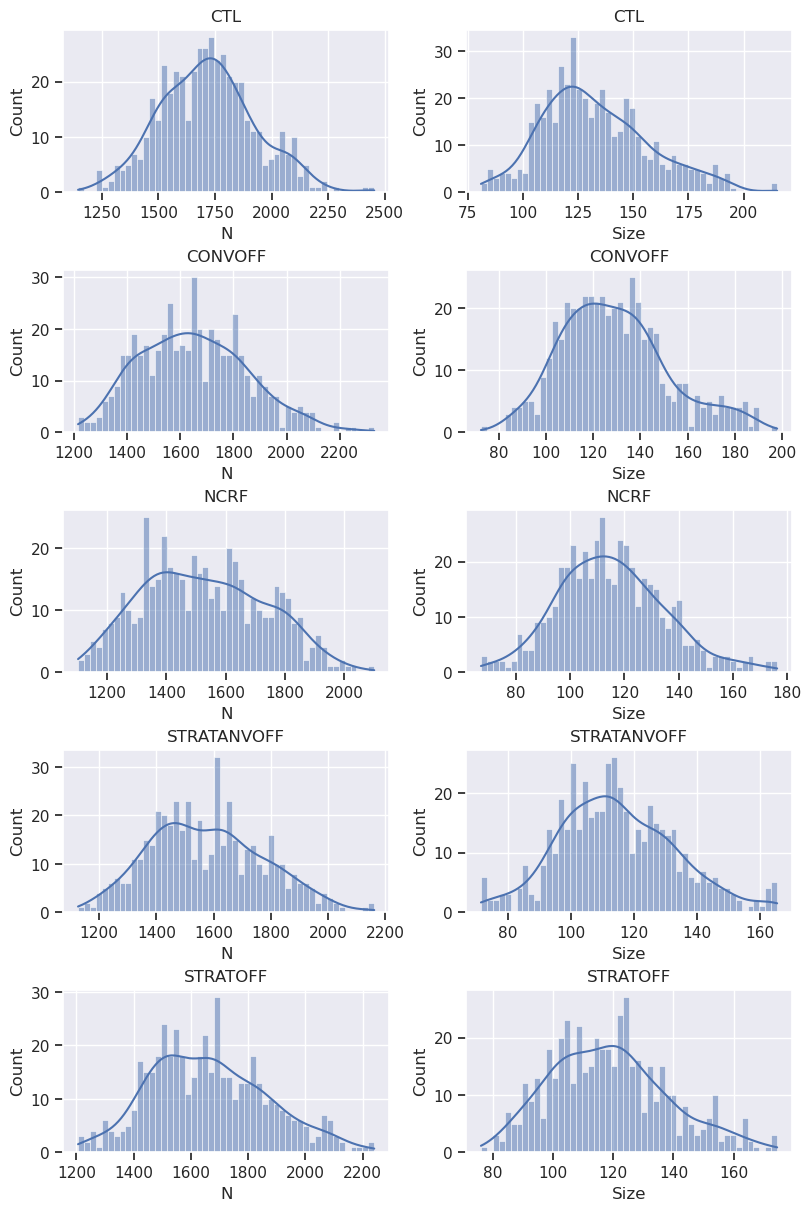

In [7]:
def add_var(figdata, ax):
    ax.set_title(figdata['testtag'])
    ax.set_ylabel('Count')
    ax.set_xlabel(figdata['units'])
    sns.histplot(figdata['pltvar'], ax=ax, kde=True, bins=figdata['bins'], legend=True)

fig_x = 8
fig_y = 12
fig, axs = plt.subplots(5, 2, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
# fig, axs = plt.subplots(layout='constrained', squeeze=True)

kpclass=4

for itest in range(ntest):

    figdata = {
        'pltvar': number[itest,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
        'testtag': tests_str[itest],
        'units': 'N',
        'bins': 50,
        }

    add_var(figdata, axs[itest,0])

    figdata = {
        'pltvar': mean_size[itest,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
        'testtag': tests_str[itest],
        'units': 'Size',
        'bins': 50,
        }

    add_var(figdata, axs[itest,1])
    # add_var(figdata, axs[0,1])

plt.show()
plt.close()

#### KDE or Box Plots

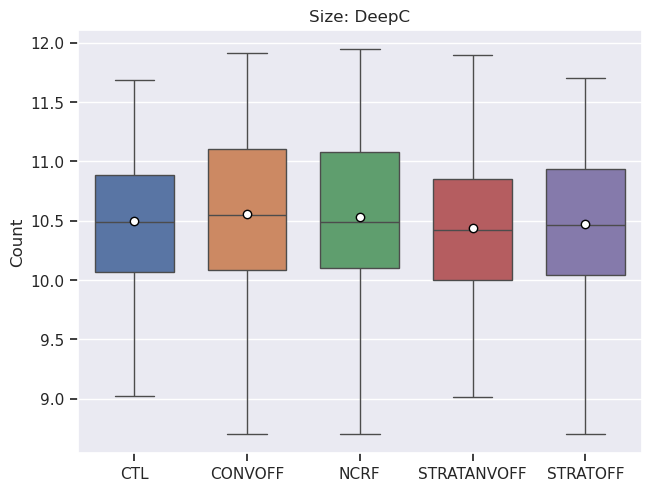

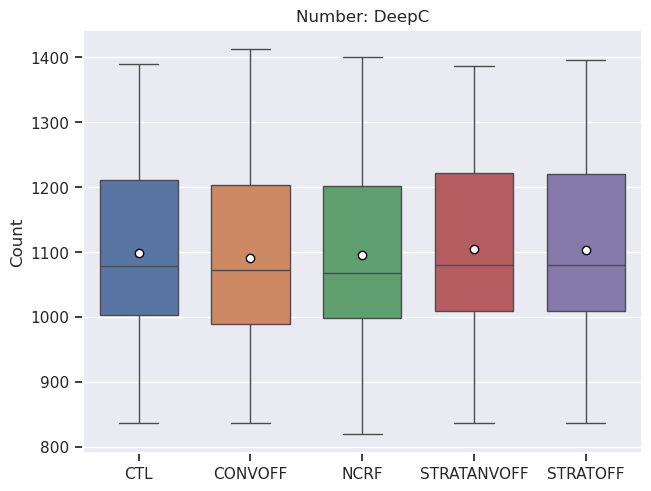

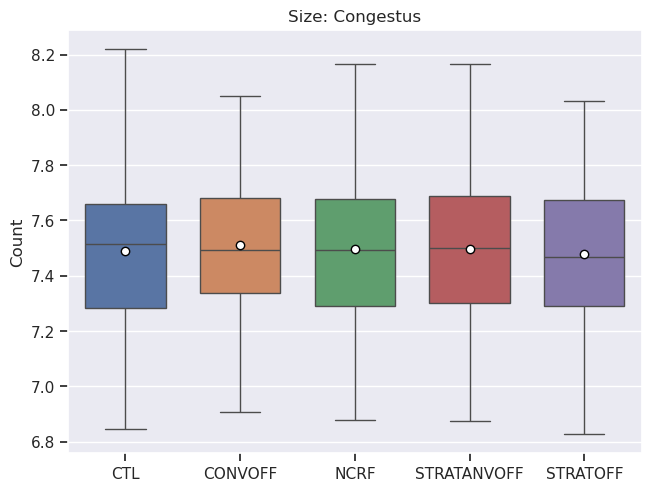

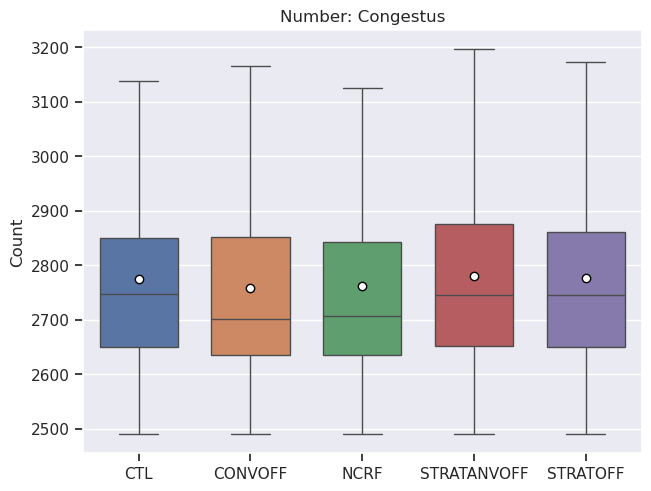

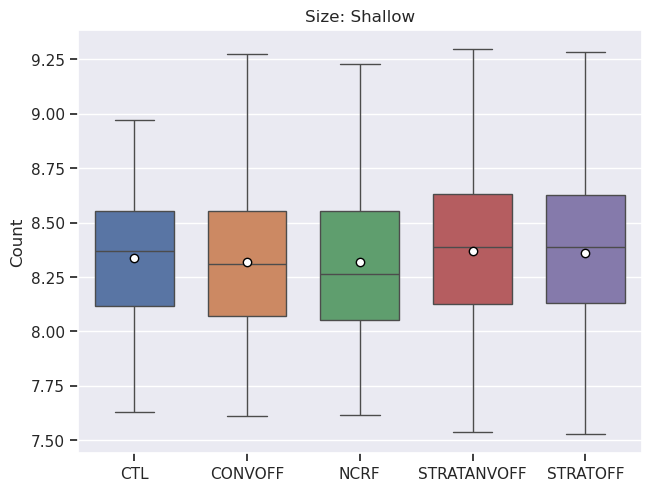

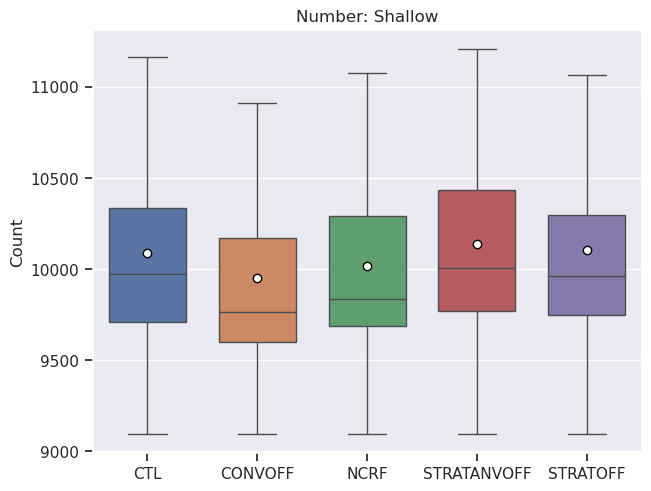

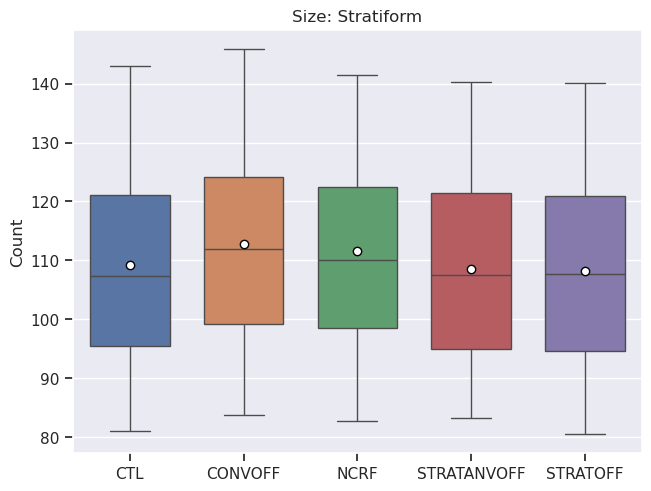

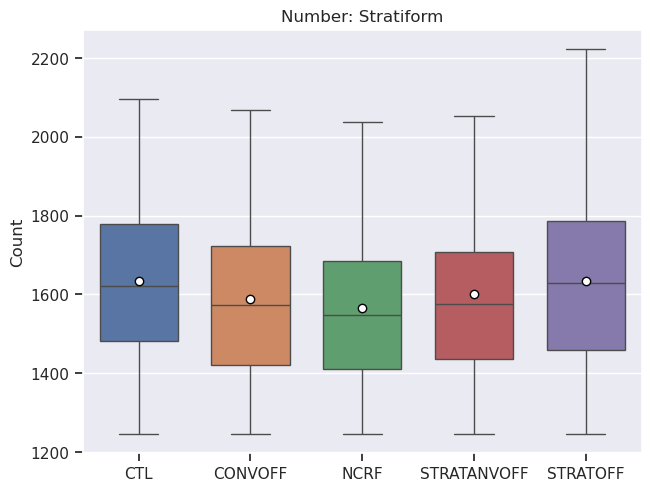

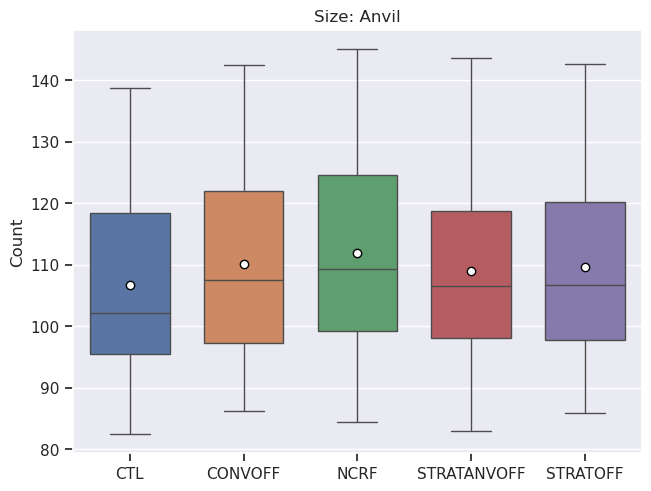

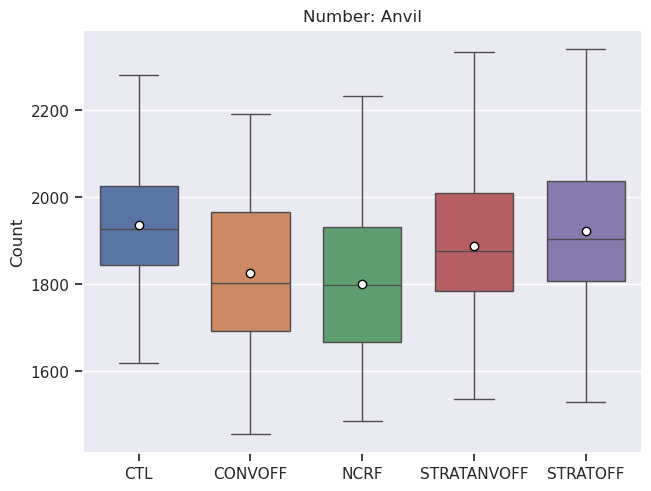

In [8]:
def do_kdeplot(figdata):
    fig, ax = plt.subplots(layout='constrained', squeeze=True)
    ax.set_title(figdata['units'])
    ax.set_ylabel('Count')
    # ax.set_xlabel(figdata['units'])
    ntnew=figdata['pltvar'].shape[2]
    df = pd.DataFrame(data=np.reshape(figdata['pltvar'], (ntest, nmem*ntnew)).transpose(), columns=tests_str)
    # sns.kdeplot(df, ax=ax, legend=True)
    sns.boxplot(df,
                width=0.7, showmeans=True, showfliers=False,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":"6"},
                )

# t_ind=range(t1_test)
t_ind=range(6)

for kpclass in range(1,npclass):

    figdata = {
        'pltvar': mean_size[:,:,kpclass,t_ind], # dims = (ntest, nmem, npclass, nt)
        'testtag': tests_str[itest],
        'units': 'Size: '+pclass_names[kpclass],
        }

    do_kdeplot(figdata)

    figdata = {
        'pltvar': number[:,:,kpclass,t_ind], # dims = (ntest, nmem, npclass, nt)
        'testtag': tests_str[itest],
        'units': 'Number: '+pclass_names[kpclass],
        }

    do_kdeplot(figdata)

#### Box plots of full cluster size distribution

In [17]:
# Function to get full distribution of cluster sizes

def get_cluster_sizes(nt_read):

    dims = (npclass, ntest, nmem)
    number = np.zeros(dims)

    cluster_size_allclass=[]
    for kpclass in range(npclass):

        cluster_size_alltest=[]
        for itest in range(ntest):
            # Loop over ensemble members
            for imemb in range(nmem):

                pickle_file1 = main_pickle+memb_all[imemb]+'/pclass_'+tests[itest]+'_48hrs.pkl'
                with open(pickle_file1, 'rb') as file:
                    pclass, ipclass_area = pickle.load(file)

                for it in range(nt_read):
                    labeled_matrix, num_features = label(pclass[it,...] == kpclass)
                    icluster_size = ndi_sum(pclass[it,...], labeled_matrix, index=np.arange(1, num_features + 1))
                    number[kpclass, itest, imemb] += num_features
                    if it == 0:
                        cluster_size = np.copy(icluster_size)
                    else:
                        cluster_size = np.concatenate((cluster_size, icluster_size))

                if imemb == 0:
                    cluster_size_allmemb = np.copy(cluster_size)
                else:
                    cluster_size_allmemb = np.concatenate((cluster_size_allmemb, cluster_size))

            cluster_size_alltest.append(cluster_size_allmemb)
        cluster_size_allclass.append(cluster_size_alltest)

    return cluster_size_allclass, number

In [13]:
nt_read=6
cluster_size, number = get_cluster_sizes(nt_read)

Running test:  CTL
Running test:  CONVOFF
Running test:  NCRF
Running test:  STRATANVOFF
Running test:  STRATOFF
Running test:  CTL
Running test:  CONVOFF
Running test:  NCRF
Running test:  STRATANVOFF
Running test:  STRATOFF
Running test:  CTL
Running test:  CONVOFF
Running test:  NCRF
Running test:  STRATANVOFF
Running test:  STRATOFF
Running test:  CTL
Running test:  CONVOFF
Running test:  NCRF
Running test:  STRATANVOFF
Running test:  STRATOFF
Running test:  CTL
Running test:  CONVOFF
Running test:  NCRF
Running test:  STRATANVOFF
Running test:  STRATOFF
Running test:  CTL
Running test:  CONVOFF
Running test:  NCRF
Running test:  STRATANVOFF
Running test:  STRATOFF


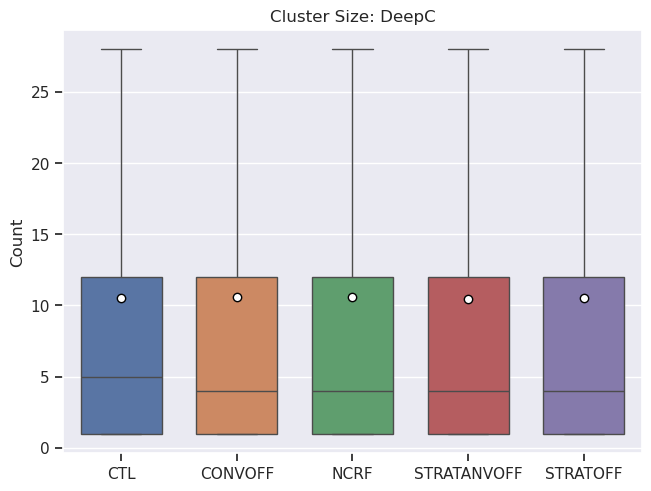

In [31]:
# Plot function
def do_cluster_plot(figdata):
    fig, ax = plt.subplots(layout='constrained', squeeze=True)
    ax.set_title(figdata['units'])
    ax.set_ylabel('Count')
    # df = pd.DataFrame(data=figdata['pltvar'], index=tests_str)
    pltvar_dict = {tests_str[itest]: figdata['pltvar'][itest] for itest in range(ntest)}
    sns.boxplot(pltvar_dict,
                width=0.7, showmeans=True, showfliers=False,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":"6"},
                )

# Sampling window
nt_read = 6

# cluster_size, number = get_cluster_sizes(nt_read)

# for kpclass in range(1,npclass):
kpclass=1

figdata = {
    'pltvar': cluster_size[kpclass], # npclass, ntest, n-flattened-clusters
    'units': 'Cluster Size: '+pclass_names[kpclass],
    }

do_cluster_plot(figdata)